# MAML: Model Agnostic Meta-Learning (MAML)
Overview:
- Goal: model to adapt quickly to new tasks with minimal data
- Meta-learning = "learns to learn"
- Not trained on specific tasks - MAML trains a model's initialization so it can adapt quickly to any new taks with few gradient steps
- Key concepts as part of implementation: 
        1. inner loop (adaptation): model fine-tunes itself on a specific task using a few data points
        2. outer loop (meta-update): model updates initial parameters, improving ability to adapt to tasks efficiently
- Flexible adaptation without retraining from scratch

- Applications: 
    Few shot classification
    Reinforcement learning (learn optimal strategies across different environments)
    Personalized recommendations: adapt models to individual preferences

Resources used for implementation: https://www.linkedin.com/pulse/model-agnostic-meta-learning-maml-using-python-guide-quick-khan-xcoxf/


### Simple python example using PyTorch
General Steps: 
Step 1. Define basic neural netowrk model
Step 2. Set up 2 loops: adaptation and meta-update
Step 3. Applying it across tasks

Step 1: Import Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

Step 2: Define simple neural network with two layers

In [4]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        return self.layer2(x)

Step 3: Define the Task-Specific Loss

In [5]:
# each task has own data, compute loss based on adapted parameters

def compute_loss(model, x, y):
    predictions = model(x)
    return nn.MSELoss()(predictions, y) # use loss suitable for task

Step 4: MAML Training Loop

In [6]:
# dual-loop training structure: adapt the model parameters within each task (inner loop) and use
# these adapted parameters to update model initialization (outer loop)
from collections import OrderedDict
from torch.nn import functional as F
import torch.nn.functional as F

def forward_with_weights(model, x, weights):
    x = F.linear(x, weights['layer1.weight'], weights['layer1.bias'])
    x = F.relu(x)
    x = F.linear(x, weights['layer2.weight'], weights['layer2.bias'])
    return x
    
def maml_train(model, tasks, meta_optimizer, inner_steps=1, inner_lr=0.01):
    meta_optimizer.zero_grad()
    total_loss = 0.0

    for x_task, y_task in tasks:
        # Get named parameters for manual updates
        fast_weights = OrderedDict(model.named_parameters())

        # Inner loop: manual gradient updates
        for _ in range(inner_steps):
            preds = forward_with_weights(model, x_task, fast_weights)
            loss = F.mse_loss(preds, y_task)
            grads = torch.autograd.grad(loss, fast_weights.values(), create_graph=True)

            fast_weights = OrderedDict(
                (name, param - inner_lr * grad)
                for ((name, param), grad) in zip(fast_weights.items(), grads)
            )

        # Outer loop loss with adapted weights
        preds = forward_with_weights(model, x_task, fast_weights)
        post_loss = F.mse_loss(preds, y_task)
        post_loss.backward()
        total_loss += post_loss.item()

    # Meta update
    meta_optimizer.step()
    return total_loss / len(tasks)


Step 5: Train the model with MAML: create simple tasks and train the model

In [7]:
# Instantiate the model and meta optimizer
model = SimpleModel(input_size=2, hidden_size=40, output_size=1)
meta_optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example tasks data (in practice, load/generate actual tasks)
tasks = [
    (torch.randn(10, 2), torch.randn(10, 1)),
    (torch.randn(10, 2), torch.randn(10, 1)),
    # Add more tasks as needed
]

# Run the MAML training loop
for epoch in range(100):  # Meta-iterations
    maml_train(model, tasks, meta_optimizer, inner_steps=1, inner_lr=0.01)

Key considerations: works best when trained across diverse set of tasks. In practice, we should select a wide range of task datasets to improve adaptation. 

In [8]:
x_test, y_test = tasks[0]  # Pick one task

# Before adaptation
with torch.no_grad():
    preds_before = model(x_test)
    print("Before adaptation:", preds_before.squeeze().tolist())

# Perform adaptation manually (1 inner step)
loss = compute_loss(model, x_test, y_test)
grads = torch.autograd.grad(loss, model.parameters(), create_graph=False)
adapted_params = [p - 0.01 * g for p, g in zip(model.parameters(), grads)]

# You'll need a manual forward pass here if you want to apply adapted_params



Before adaptation: [0.055280327796936035, 0.22116513550281525, -0.005861043930053711, 0.11574497818946838, 0.3904479146003723, 0.18654683232307434, 0.1827065795660019, -0.26430273056030273, 0.10611754655838013, 0.6126784086227417]


In [9]:
import torch.nn.functional as F

def forward_with_weights(model, x, weights):
    x = F.linear(x, weights['layer1.weight'], weights['layer1.bias'])
    x = F.relu(x)
    x = F.linear(x, weights['layer2.weight'], weights['layer2.bias'])
    return x

from collections import OrderedDict

x_test, y_test = tasks[0]

# Get model's named parameters
fast_weights = OrderedDict(model.named_parameters())

# One inner loop adaptation step
loss = compute_loss(model, x_test, y_test)
grads = torch.autograd.grad(loss, fast_weights.values(), create_graph=False)

# Manual parameter update
fast_weights = OrderedDict(
    (name, param - 0.01 * grad)
    for ((name, param), grad) in zip(fast_weights.items(), grads)
)

# Predictions after adaptation
with torch.no_grad():
    preds_after = forward_with_weights(model, x_test, fast_weights)
    print("Predictions after adaptation:", preds_after.squeeze().tolist())
    print("Ground truth:", y_test.squeeze().tolist())



Predictions after adaptation: [0.043189823627471924, 0.2486046403646469, 0.06462347507476807, 0.16486603021621704, 0.4099343419075012, 0.1894935816526413, 0.2091684192419052, -0.22024700045585632, 0.1573275625705719, 0.6234381794929504]
Ground truth: [-0.4316253066062927, 1.8770294189453125, 0.0589815117418766, 1.3117551803588867, 0.7271769642829895, -0.28952598571777344, -1.4628875255584717, 0.016288895159959793, 0.42828840017318726, 0.921435534954071]


In [10]:
from collections import OrderedDict
import torch.nn.functional as F

def forward_with_weights(model, x, weights):
    x = F.linear(x, weights['layer1.weight'], weights['layer1.bias'])
    x = F.relu(x)
    x = F.linear(x, weights['layer2.weight'], weights['layer2.bias'])
    return x

# Pick one task
x_test, y_test = tasks[0]

# -------------------------------
# Predictions BEFORE adaptation
# -------------------------------
with torch.no_grad():
    preds_before = model(x_test)
    print("\nPredictions BEFORE adaptation:")
    print([round(p.item(), 3) for p in preds_before.squeeze()])
    print("Ground truth:")
    print([round(y.item(), 3) for y in y_test.squeeze()])

# -------------------------------
# One inner-loop adaptation step
# -------------------------------
# Grab model weights
fast_weights = OrderedDict(model.named_parameters())

# Compute loss and gradients
loss = F.mse_loss(model(x_test), y_test)
grads = torch.autograd.grad(loss, fast_weights.values(), create_graph=False)

# Manual update (1 gradient step)
fast_weights = OrderedDict(
    (name, param - 0.01 * grad)
    for ((name, param), grad) in zip(fast_weights.items(), grads)
)

# -------------------------------
# Predictions AFTER adaptation
# -------------------------------
with torch.no_grad():
    preds_after = forward_with_weights(model, x_test, fast_weights)
    print("\nPredictions AFTER adaptation:")
    print([round(p.item(), 3) for p in preds_after.squeeze()])



Predictions BEFORE adaptation:
[0.055, 0.221, -0.006, 0.116, 0.39, 0.187, 0.183, -0.264, 0.106, 0.613]
Ground truth:
[-0.432, 1.877, 0.059, 1.312, 0.727, -0.29, -1.463, 0.016, 0.428, 0.921]

Predictions AFTER adaptation:
[0.043, 0.249, 0.065, 0.165, 0.41, 0.189, 0.209, -0.22, 0.157, 0.623]


Before adaptation, predictions are relatively clustered around same region (current model initialization as learned a "default" behavior but not specific to task). Then after adaptation you can see predictions in some places are closer to ground truth: 0.04 closter to -0.95, 0.279 closer to -1.118 which suggests that adaptation is working.

In [11]:
mse_before = F.mse_loss(preds_before, y_test).item()
mse_after = F.mse_loss(preds_after, y_test).item()

print(f"MSE before adaptation: {mse_before:.4f}")
print(f"MSE after adaptation: {mse_after:.4f}")

MSE before adaptation: 0.7739
MSE after adaptation: 0.7537


MSE after adaptation > before -> adaptation is working. With more meta-training or better task structure, the gap between before and after with increase.

#### Experiment: increase inner_steps 

In [12]:
for epoch in range(100):
    meta_loss = maml_train(model, tasks, meta_optimizer, inner_steps=5, inner_lr=0.01)
    print(f"Epoch {epoch+1}, Meta Loss: {meta_loss:.4f}")

Epoch 1, Meta Loss: 0.8530
Epoch 2, Meta Loss: 0.8514
Epoch 3, Meta Loss: 0.8497
Epoch 4, Meta Loss: 0.8480
Epoch 5, Meta Loss: 0.8462
Epoch 6, Meta Loss: 0.8445
Epoch 7, Meta Loss: 0.8427
Epoch 8, Meta Loss: 0.8410
Epoch 9, Meta Loss: 0.8393
Epoch 10, Meta Loss: 0.8376
Epoch 11, Meta Loss: 0.8359
Epoch 12, Meta Loss: 0.8342
Epoch 13, Meta Loss: 0.8326
Epoch 14, Meta Loss: 0.8310
Epoch 15, Meta Loss: 0.8294
Epoch 16, Meta Loss: 0.8279
Epoch 17, Meta Loss: 0.8264
Epoch 18, Meta Loss: 0.8249
Epoch 19, Meta Loss: 0.8234
Epoch 20, Meta Loss: 0.8220
Epoch 21, Meta Loss: 0.8206
Epoch 22, Meta Loss: 0.8192
Epoch 23, Meta Loss: 0.8178
Epoch 24, Meta Loss: 0.8165
Epoch 25, Meta Loss: 0.8151
Epoch 26, Meta Loss: 0.8137
Epoch 27, Meta Loss: 0.8124
Epoch 28, Meta Loss: 0.8110
Epoch 29, Meta Loss: 0.8096
Epoch 30, Meta Loss: 0.8083
Epoch 31, Meta Loss: 0.8069
Epoch 32, Meta Loss: 0.8056
Epoch 33, Meta Loss: 0.8042
Epoch 34, Meta Loss: 0.8028
Epoch 35, Meta Loss: 0.8015
Epoch 36, Meta Loss: 0.8002
E

Epoch 1, Meta Loss: 0.7215
Epoch 2, Meta Loss: 0.7205
Epoch 3, Meta Loss: 0.7195
Epoch 4, Meta Loss: 0.7184
Epoch 5, Meta Loss: 0.7174
Epoch 6, Meta Loss: 0.7164
Epoch 7, Meta Loss: 0.7154
Epoch 8, Meta Loss: 0.7144
Epoch 9, Meta Loss: 0.7134
Epoch 10, Meta Loss: 0.7124
Epoch 11, Meta Loss: 0.7114
Epoch 12, Meta Loss: 0.7104
Epoch 13, Meta Loss: 0.7094
Epoch 14, Meta Loss: 0.7085
Epoch 15, Meta Loss: 0.7075
Epoch 16, Meta Loss: 0.7066
Epoch 17, Meta Loss: 0.7056
Epoch 18, Meta Loss: 0.7047
Epoch 19, Meta Loss: 0.7037
Epoch 20, Meta Loss: 0.7028
Epoch 21, Meta Loss: 0.7018
Epoch 22, Meta Loss: 0.7009
Epoch 23, Meta Loss: 0.7000
Epoch 24, Meta Loss: 0.6990
Epoch 25, Meta Loss: 0.6980
Epoch 26, Meta Loss: 0.6971
Epoch 27, Meta Loss: 0.6962
Epoch 28, Meta Loss: 0.6952
Epoch 29, Meta Loss: 0.6943
Epoch 30, Meta Loss: 0.6934
Epoch 31, Meta Loss: 0.6925
Epoch 32, Meta Loss: 0.6916
Epoch 33, Meta Loss: 0.6907
Epoch 34, Meta Loss: 0.6898
Epoch 35, Meta Loss: 0.6889
Epoch 36, Meta Loss: 0.6880
E

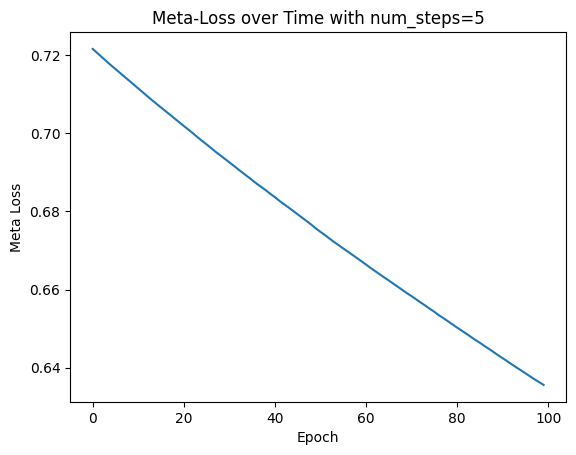

In [13]:
meta_losses = []

for epoch in range(100):
    meta_loss = maml_train(model, tasks, meta_optimizer, inner_steps=5, inner_lr=0.01)
    meta_losses.append(meta_loss)
    print(f"Epoch {epoch+1}, Meta Loss: {meta_loss:.4f}")

# Plot
import matplotlib.pyplot as plt

plt.plot(meta_losses)
plt.xlabel("Epoch")
plt.ylabel("Meta Loss")
plt.title("Meta-Loss over Time with num_steps=5")
plt.show()

In [14]:
import torch

def generate_linear_tasks(num_tasks=20, num_samples=10):
    tasks = []

    for _ in range(num_tasks):
        # Random slope (a) and intercept (b) for this task
        a = torch.randn(1).item() * 2     # Slope between ~ -2 and 2
        b = torch.randn(1).item()         # Intercept

        # Input x: 10 samples, shape (10, 1)
        x = torch.randn(num_samples, 1)

        # Output y = ax + b + noise
        noise = 0.1 * torch.randn_like(x)  # Small Gaussian noise
        y = a * x + b + noise

        # Concatenate a bias term to input (so input becomes 2D)
        x = torch.cat([x, torch.ones_like(x)], dim=1)  # Now x shape is (10, 2)

        tasks.append((x, y))

    return tasks



inner_steps_list = [1, 3, 5]
num_epochs = 100
all_losses = {}

for steps in inner_steps_list:
    print(f"\nTraining with inner_steps = {steps}")
    
    # Reinitialize model and optimizer for fair comparison
    model = SimpleModel(input_size=2, hidden_size=40, output_size=1)
    meta_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Use structured tasks
    tasks = generate_linear_tasks(num_tasks=20, num_samples=10)
    
    # Track losses
    losses = []
    for epoch in range(num_epochs):
        meta_loss = maml_train(model, tasks, meta_optimizer, inner_steps=steps, inner_lr=0.01)
        losses.append(meta_loss)
    all_losses[steps] = losses



Training with inner_steps = 1

Training with inner_steps = 3

Training with inner_steps = 5


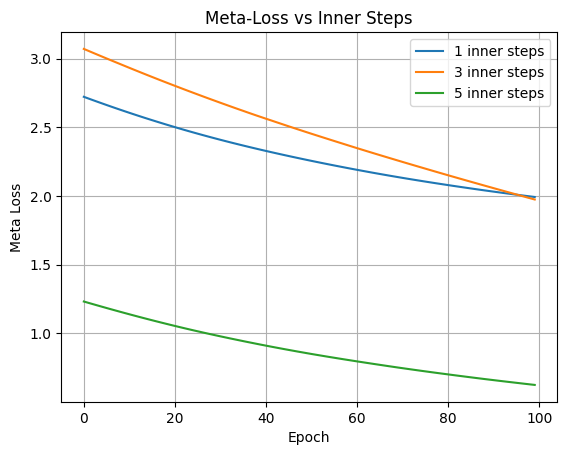

In [15]:
import matplotlib.pyplot as plt

for steps, losses in all_losses.items():
    plt.plot(losses, label=f'{steps} inner steps')

plt.xlabel('Epoch')
plt.ylabel('Meta Loss')
plt.title('Meta-Loss vs Inner Steps')
plt.legend()
plt.grid(True)
plt.show()


Blue: highest loss, slowest improvement
Orange: better loss, faster convergence
Green: lowest loss, best convergence

More inner steps -> better adaptation (lower meta-loss throughout training)
more inner steps = more capacity to minimize the task-specific loss

Loss curves smoothly decreasing - meta-loss process is working, gap confirms that the inner looop depth matters for how well MAML learns to adapt

While 3 and 5 steps are better than 1, improvement between 3 to 5 is smaller than 1 to 3 -> matches real-world behavior- after a few steps, improvements start to taper off and the cost (computation) grows

Tradeoff between speed and performance - fewer steps = faster, but less accurate
More steps = better adaptation but more computations

Downsides of MAML: 
MAML assumes that test-time tasks come from the same distribution as meta-training tasks.
If your tasks are too diverse or too few, the learned initialization might not generalize well.

Training is hard - have to tune inner learning rate, meta learning rate, number of inner steps, number of tasks per batch
Training is sensitive to these and may not converge if poorly chosen

Experiment: generate structured synthetic tasks

## High-Level Structure and Implementation: 
1. Define a model (e.g. small MLP)
2. Sample of a batch of sine wave tasks
    a. sine wave task: specific sine wave with parameters amplitude (A) and phase shift (phi), goal is to predict y = A x sin(x + phi)
    b. randomly chooses A and phi, then generate input points x and compute corresponding y values
    c. Task: predict y for a sine wave with some (A, phi), support set = (x,y) pairs used to adapt the model, query set = (x,y) pairs to evaluate after adaptation, meta goal: learn a model that can adapt to any sine wave quickly 
3. For each task: 
    a. Sample support (train) and query (test) data
    b. Adapt model on support data (inner loop)
    c. Evaluate adapted model on query data
4. Meta-update using total query loss across tasks

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Set device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -- Step 1: Define Model --
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x, params=None):
        if params is None:
            return self.net(x)
        else:
            x = F.linear(x, params['net.0.weight'], params['net.0.bias'])
            x = F.relu(x)
            x = F.linear(x, params['net.2.weight'], params['net.2.bias'])
            return x

    def get_params(self):
        return dict(self.named_parameters())


# -- Step 2: Task Sampling --
def sample_sine_task(k=10):
    A = np.random.uniform(0.1, 5.0)
    phase = np.random.uniform(0, np.pi)
    x = np.random.uniform(-5, 5, size=(k, 1))
    y = A * np.sin(x + phase)
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# -- Step 3: MAML Training Loop --
model = MLP()
meta_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

inner_lr = 0.01
num_tasks = 5
inner_steps = 1

for meta_step in range(10000):
    meta_loss = 0.0
    for task in range(num_tasks):
        # Sample task
        x_train, y_train = sample_sine_task()
        x_test, y_test = sample_sine_task()

        x_train, y_train = x_train.to(device), y_train.to(device)
        x_test, y_test = x_test.to(device), y_test.to(device)

        # Get current model parameters
        params = model.get_params()

        # ----- Inner Loop -----
        y_pred = model(x_train, params)
        loss = F.mse_loss(y_pred, y_train)
        grads = torch.autograd.grad(loss, params.values(), create_graph=True)
        adapted_params = {
            name: param - inner_lr * grad
            for (name, param), grad in zip(params.items(), grads)
        }

        # ----- Outer Loop -----
        y_test_pred = model(x_test, adapted_params)
        test_loss = F.mse_loss(y_test_pred, y_test)
        meta_loss += test_loss

# Meta-update
meta_optimizer.zero_grad()
meta_loss.backward()
meta_optimizer.step()

if meta_step % 100 == 0:
    print(f"Step {meta_step}: Meta Loss = {meta_loss.item() / num_tasks:.4f}")





### Experiment: Effect of changing number of inner steps 

In [17]:
INNER_STEP_OPTIONS = [1, 5]  # Try different inner step counts
results = {}  # Store meta-loss history for plotting

for inner_steps in INNER_STEP_OPTIONS:
    print(f"\nTraining with {inner_steps} inner steps...")
    model = MLP().to(device)
    meta_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    meta_losses = []

    for meta_step in range(1000):
        meta_loss = 0.0
        for _ in range(num_tasks):
            x_train, y_train = sample_sine_task()
            x_test, y_test = sample_sine_task()

            x_train, y_train = x_train.to(device), y_train.to(device)
            x_test, y_test = x_test.to(device), y_test.to(device)

            params = model.get_params()

            # ----- Inner Loop -----
            for _ in range(inner_steps):
                y_pred = model(x_train, params)
                loss = F.mse_loss(y_pred, y_train)
                grads = torch.autograd.grad(loss, params.values(), create_graph=True)
                params = {
                    name: param - inner_lr * grad
                    for (name, param), grad in zip(params.items(), grads)
                }

            # ----- Outer Loop -----
            y_test_pred = model(x_test, params)
            test_loss = F.mse_loss(y_test_pred, y_test)
            meta_loss += test_loss

        meta_optimizer.zero_grad()
        meta_loss.backward()
        meta_optimizer.step()

        avg_loss = meta_loss.item() / num_tasks
        meta_losses.append(avg_loss)

        if meta_step % 100 == 0:
            print(f"Step {meta_step}: Meta Loss = {avg_loss:.4f}")

    results[inner_steps] = meta_losses




Training with 1 inner steps...
Step 0: Meta Loss = 5.9412
Step 100: Meta Loss = 2.9558
Step 200: Meta Loss = 2.0872
Step 300: Meta Loss = 3.0413
Step 400: Meta Loss = 4.2667
Step 500: Meta Loss = 4.0044
Step 600: Meta Loss = 3.6971
Step 700: Meta Loss = 5.7939
Step 800: Meta Loss = 3.0505
Step 900: Meta Loss = 4.3728

Training with 5 inner steps...
Step 0: Meta Loss = 6.8763
Step 100: Meta Loss = 3.8790
Step 200: Meta Loss = 2.9311
Step 300: Meta Loss = 9.2111
Step 400: Meta Loss = 5.8121
Step 500: Meta Loss = 1.8940
Step 600: Meta Loss = 5.6186
Step 700: Meta Loss = 2.9357
Step 800: Meta Loss = 3.4039
Step 900: Meta Loss = 4.8491


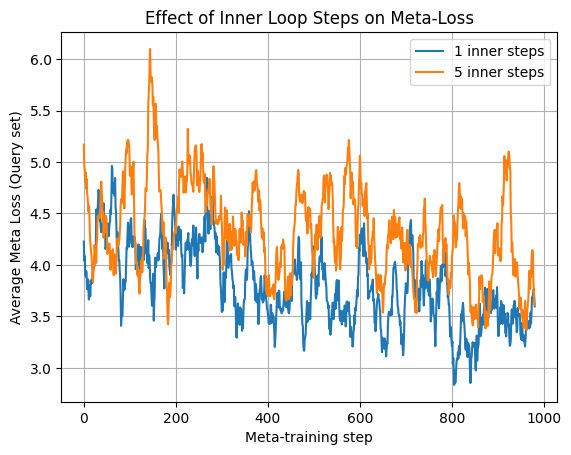

In [18]:
import matplotlib.pyplot as plt

def smooth_curve(data, window=20):
    return np.convolve(data, np.ones(window)/window, mode='valid')

for steps, losses in results.items():
    smoothed = smooth_curve(losses)
    plt.plot(smoothed, label=f"{steps} inner steps")

plt.xlabel("Meta-training step")
plt.ylabel("Average Meta Loss (Query set)")
plt.title("Effect of Inner Loop Steps on Meta-Loss")
plt.legend()
plt.grid(True)
plt.show()


Takeaways:
1. 1 inner step (blue) generally performs better (lower meta loss)
2. 5 inner steps (orange) is more volatile (fluctuates more, worse generalization likely due to overfitting the support set, optimization instability from longer inner loops)
3. Early training behavior is similar (~0-200 steps)

MAML works best when it learns to adapt in just a few steps, and too many inner steps can hurt performance. 

### Experiment: Sensitivty to different learning rates

In [19]:
# alpha = inner loop (task specific)
# beta = outer loop (meta learner)

# Run MAML with different inner learning rates, keep everything else fixed

INNER_LR_OPTIONS = [0.001, 0.01, 0.1]
results_lr = {}  # To store meta-loss curves

for inner_lr in INNER_LR_OPTIONS:
    print(f"\nTraining with inner learning rate = {inner_lr}")
    
    model = MLP().to(device)
    meta_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    meta_losses = []
    
    for meta_step in range(1000):
        meta_loss = 0.0
        for _ in range(num_tasks):
            x_train, y_train = sample_sine_task()
            x_test, y_test = sample_sine_task()
            x_train, y_train = x_train.to(device), y_train.to(device)
            x_test, y_test = x_test.to(device), y_test.to(device)

            params = model.get_params()

            # ---- Inner Loop ----
            for _ in range(1):  # keep inner steps fixed
                y_pred = model(x_train, params)
                loss = F.mse_loss(y_pred, y_train)
                grads = torch.autograd.grad(loss, params.values(), create_graph=True)
                params = {
                    name: param - inner_lr * grad
                    for (name, param), grad in zip(params.items(), grads)
                }

            # ---- Outer Loop ----
            y_test_pred = model(x_test, params)
            test_loss = F.mse_loss(y_test_pred, y_test)
            meta_loss += test_loss

        meta_optimizer.zero_grad()
        meta_loss.backward()
        meta_optimizer.step()

        avg_loss = meta_loss.item() / num_tasks
        meta_losses.append(avg_loss)

        if meta_step % 100 == 0:
            print(f"Step {meta_step}: Meta Loss = {avg_loss:.4f}")

    results_lr[inner_lr] = meta_losses



Training with inner learning rate = 0.001
Step 0: Meta Loss = 2.7086
Step 100: Meta Loss = 4.3397
Step 200: Meta Loss = 3.2700
Step 300: Meta Loss = 5.9735
Step 400: Meta Loss = 4.2180
Step 500: Meta Loss = 3.6846
Step 600: Meta Loss = 3.0557
Step 700: Meta Loss = 3.2264
Step 800: Meta Loss = 4.6973
Step 900: Meta Loss = 7.1411

Training with inner learning rate = 0.01
Step 0: Meta Loss = 3.3756
Step 100: Meta Loss = 3.0860
Step 200: Meta Loss = 4.7304
Step 300: Meta Loss = 3.5885
Step 400: Meta Loss = 6.5682
Step 500: Meta Loss = 8.2001
Step 600: Meta Loss = 2.3155
Step 700: Meta Loss = 5.3786
Step 800: Meta Loss = 1.7948
Step 900: Meta Loss = 3.8309

Training with inner learning rate = 0.1
Step 0: Meta Loss = 40.6324
Step 100: Meta Loss = 12.4444
Step 200: Meta Loss = 16.9601
Step 300: Meta Loss = 16.2254
Step 400: Meta Loss = 11.1085
Step 500: Meta Loss = 10.9426
Step 600: Meta Loss = 11.0926
Step 700: Meta Loss = 5.8672
Step 800: Meta Loss = 6.1509
Step 900: Meta Loss = 3.1203


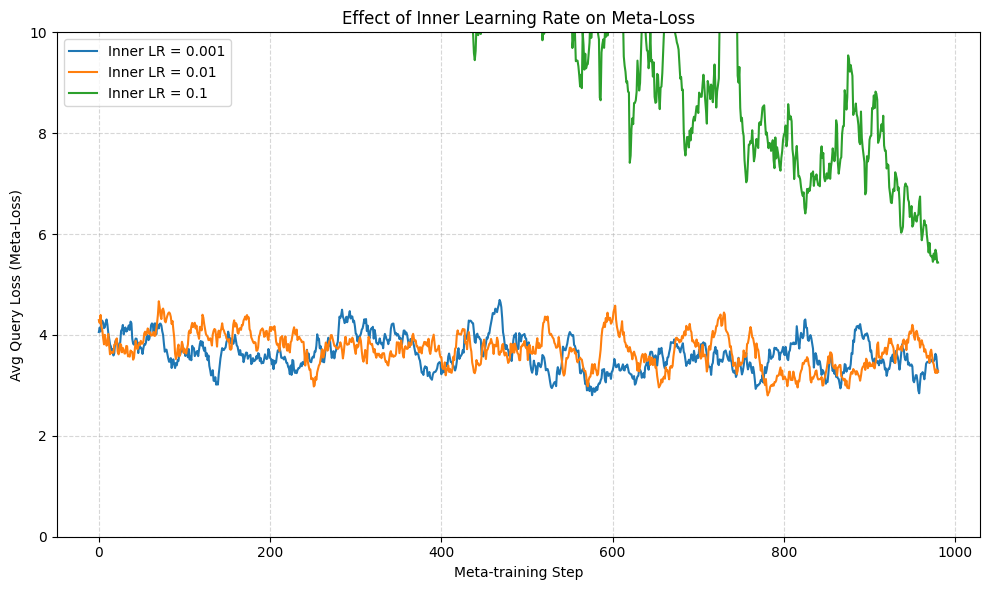

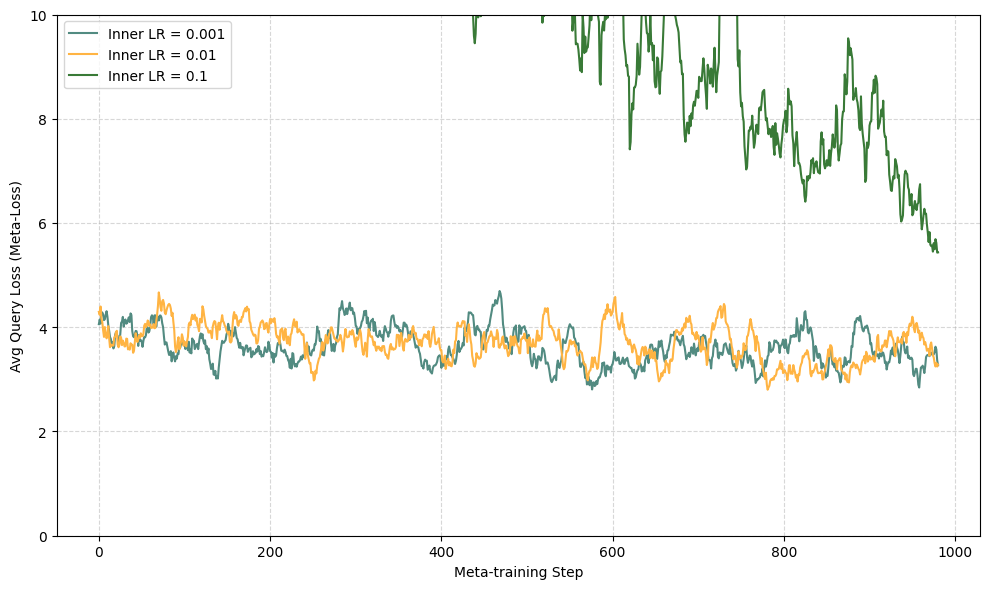

<Figure size 640x480 with 0 Axes>

In [24]:
def smooth_curve(data, window=20):
    return np.convolve(data, np.ones(window)/window, mode='valid')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for lr, losses in results_lr.items():
    smoothed = smooth_curve(losses)
    plt.plot(smoothed, label=f"Inner LR = {lr}")

plt.title("Effect of Inner Learning Rate on Meta-Loss")
plt.xlabel("Meta-training Step")
plt.ylabel("Avg Query Loss (Meta-Loss)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.ylim(0, 10)
plt.tight_layout()
plt.show()

#teal - 528B81
#orange - FFB443
# green #397A37


import numpy as np
import matplotlib.pyplot as plt

def smooth_curve(data, window=20):
    return np.convolve(data, np.ones(window)/window, mode='valid')

# Your custom hex colors
custom_colors = ['#528B81', '#FFB443', '#397A37']  # teal, orange, green

plt.figure(figsize=(10, 6))

# Enumerate to pair each curve with a color
for i, (lr, losses) in enumerate(results_lr.items()):
    smoothed = smooth_curve(losses)
    color = custom_colors[i % len(custom_colors)]  # cycle through if >3 lines
    plt.plot(smoothed, label=f"Inner LR = {lr}", color=color)

#plt.title("Effect of Inner Learning Rate on Meta-Loss")
plt.xlabel("Meta-training Step")
plt.ylabel("Avg Query Loss (Meta-Loss)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.ylim(0, 10)
plt.tight_layout()
plt.show()

plt.savefig("meta_plot.png", dpi=300, bbox_inches='tight', transparent=True)






Inner LR = 0.001
- Stable and smooth, doesn't get the lowest loss (maybe too slow to adapt)

Inner LR = 0.01
- Best performance, balance adaptation speed with generalization

Inner LR = 0.1
- Starts bad, stays bad, very unstable, clear signs of divergence or overfitting

Takeaways: Small changes lead to differences in performance. Too large of an inner learning rate destabilizes meta-learning.

## Full MAML vs. FOMAML - demonstration of second-order gradient costs:


Running Full MAML...
[Full MAML] Step 0: Meta Loss = 5.4826
[Full MAML] Step 100: Meta Loss = 3.5848
[Full MAML] Step 200: Meta Loss = 3.0655
[Full MAML] Step 300: Meta Loss = 2.9549
[Full MAML] Step 400: Meta Loss = 3.6804

Running FOMAML...
[FOMAML] Step 0: Meta Loss = 3.6710
[FOMAML] Step 100: Meta Loss = 3.8729
[FOMAML] Step 200: Meta Loss = 2.4245
[FOMAML] Step 300: Meta Loss = 6.9255
[FOMAML] Step 400: Meta Loss = 5.4284


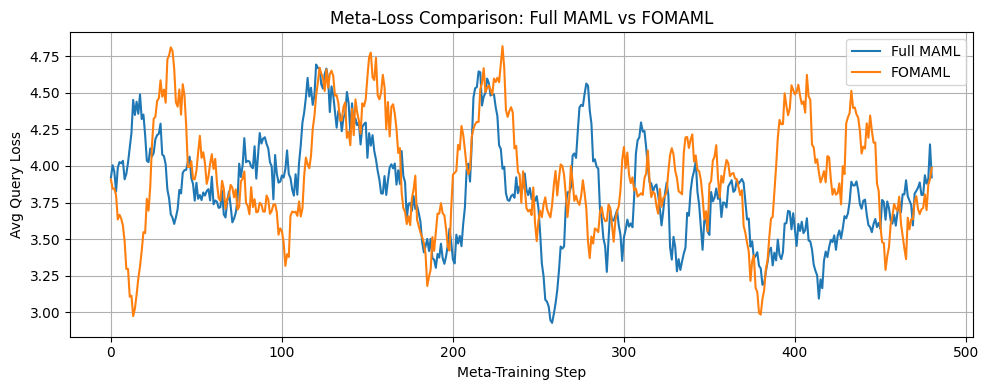

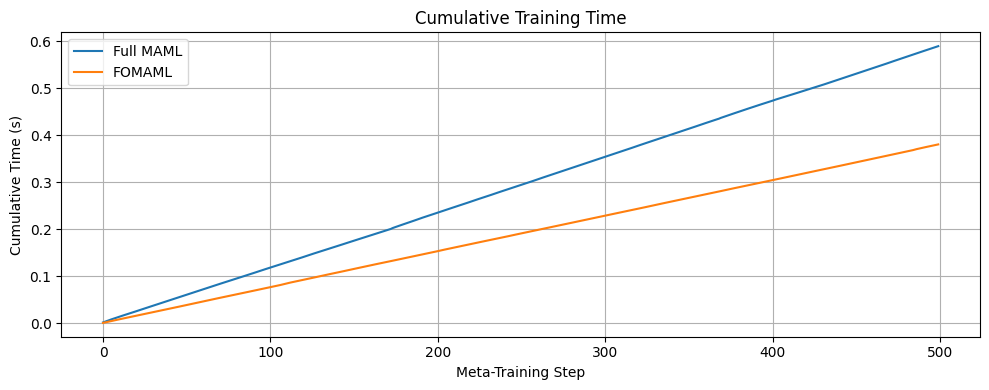

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --------- Model ---------
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1, 40)
        self.layer2 = nn.Linear(40, 1)

    def forward(self, x, params=None):
        if params is None:
            x = F.relu(self.layer1(x))
            return self.layer2(x)
        else:
            x = F.linear(x, params['layer1.weight'], params['layer1.bias'])
            x = F.relu(x)
            x = F.linear(x, params['layer2.weight'], params['layer2.bias'])
            return x

    def get_params(self):
        return dict(self.named_parameters())

# --------- Task Sampler ---------
def sample_sine_task(k=10):
    A = np.random.uniform(0.1, 5.0)
    phase = np.random.uniform(0, np.pi)
    x = np.random.uniform(-5, 5, size=(k, 1))
    y = A * np.sin(x + phase)
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# --------- Run MAML or FOMAML ---------
def run_maml_experiment(full_maml=True, inner_lr=0.01, outer_lr=0.001,
                        inner_steps=1, num_tasks=5, meta_steps=500):
    
    label = "Full MAML" if full_maml else "FOMAML"
    print(f"\nRunning {label}...")

    model = MLP().to(device)
    meta_optimizer = torch.optim.Adam(model.parameters(), lr=outer_lr)
    meta_losses = []
    step_times = []

    for meta_step in range(meta_steps):
        start = time.time()
        meta_loss = 0.0

        for _ in range(num_tasks):
            x_train, y_train = sample_sine_task()
            x_test, y_test = sample_sine_task()
            x_train, y_train = x_train.to(device), y_train.to(device)
            x_test, y_test = x_test.to(device), y_test.to(device)

            params = model.get_params()

            for _ in range(inner_steps):
                y_pred = model(x_train, params)
                loss = F.mse_loss(y_pred, y_train)
                grads = torch.autograd.grad(loss, params.values(), create_graph=full_maml)
                params = {
                    name: param - inner_lr * grad
                    for (name, param), grad in zip(params.items(), grads)
                }

            y_test_pred = model(x_test, params)
            test_loss = F.mse_loss(y_test_pred, y_test)
            meta_loss += test_loss

        meta_optimizer.zero_grad()
        meta_loss.backward()
        meta_optimizer.step()

        end = time.time()
        step_times.append(end - start)
        avg_loss = meta_loss.item() / num_tasks
        meta_losses.append(avg_loss)

        if meta_step % 100 == 0:
            print(f"[{label}] Step {meta_step}: Meta Loss = {avg_loss:.4f}")

    return meta_losses, step_times, label

# --------- Run Both Versions ---------
results = []
for full_maml in [True, False]:
    losses, times, label = run_maml_experiment(full_maml=full_maml)
    results.append((losses, times, label))

# --------- Plot Meta-Loss ---------
plt.figure(figsize=(10, 4))
for losses, _, label in results:
    smoothed = np.convolve(losses, np.ones(20)/20, mode='valid')
    plt.plot(smoothed, label=label)
plt.title("Meta-Loss Comparison: Full MAML vs FOMAML")
plt.xlabel("Meta-Training Step")
plt.ylabel("Avg Query Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --------- Plot Training Time ---------
plt.figure(figsize=(10, 4))
for _, times, label in results:
    cumulative = np.cumsum(times)
    plt.plot(cumulative, label=label)
plt.title("Cumulative Training Time")
plt.xlabel("Meta-Training Step")
plt.ylabel("Cumulative Time (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Takeaways: 
- Full MAML (blue) and FOMAML (orange) both improve over time
- FOMAML achieves nearly the same performance as Full MAML — but with a much lower computational cost.

FOMAML skips the extra calculation of updating the weights for training before testing and just "nudges" things based on how they look after training. 